Imports:

In [13]:
import numpy as np
import numpy.matlib as matl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from IPython.display import display

import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
from sklearn.model_selection import GridSearchCV

np.random.seed(19)

Carga de datos:

In [14]:
# Cargamos los datos:
fP = 'https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns
display(dfP.head())
print(dfP.shape)

,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)


Partición train-test:

In [15]:
# Separamos en dos conjuntos, training y test:
X = dfP[lVarsTarg[:-1]].astype(float)
clases = dfP['label']
X_train, X_test, clases_train, clases_test = train_test_split(X, clases, test_size=0.3, random_state=10)

Número de ejemplos de cada clase en training:

In [16]:
num_train = clases_train.shape[0]
num_test = clases_test.shape[0]
print(num_train)
print(clases_train.value_counts())
print(clases_train.value_counts()/num_train)

537
label
0    356
1    181
Name: count, dtype: int64
label
0    0.662942
1    0.337058
Name: count, dtype: float64


Estandarizamos los datos:

In [17]:
# Estandarizamos los datos:
scalerX = skpp.StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

print(X_train.mean(axis=0))
print(X_train.std(axis=0))

print(X_test.mean(axis=0))
print(X_test.std(axis=0))

[-5.62347603e-17  5.78887238e-18 -2.69596057e-16 -8.93140310e-17
 -7.93902498e-17  3.22522890e-16  6.61585415e-17 -2.77865874e-16]
[1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.0497026  -0.04582168 -0.05251802 -0.12008306 -0.15345314  0.01221576
  0.08969106  0.02221838]
[1.02866305 0.89779415 1.03384923 1.05189522 0.74468814 1.0280425
 0.97575669 0.98570541]


Construcción del clasificador y ajuste de parámetros mediante validación cruzada:

In [18]:
grid = [{'C': [1, 10, 100],
         'gamma': [10.0, 1.0, 0.1, 0.01],
         'kernel': ['rbf']}]

clf_gridsearch = GridSearchCV(estimator=SVC(probability=True), param_grid=grid, cv=5)
clf_gridsearch.fit(X_train, clases_train.values)

# Imprimimos los resultados para el mejor clasificador:
print("Best score = %f" % (clf_gridsearch.best_score_))
clf = clf_gridsearch.best_estimator_
print("Best model:")
print(clf)

# Calculamos el acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(X_train, clases_train.values)
print("Score in training set = %f" % (score_train))

score_test = clf.score(X_test, clases_test.values)
print("Score in test set = %f" % (score_test))

Best score = 0.789512
Best model:
SVC(C=1, gamma=0.1, probability=True)
Score in training set = 0.834264
Score in test set = 0.744589


### Otras métricas de evaluación:

Tasa de acierto (accuracy):

In [19]:
preds_train = clf.predict(X_train)
acc_train = float(np.sum(preds_train == clases_train)) / num_train
print("Acc. train = %f" % acc_train)
preds_test = clf.predict(X_test)
acc_test = float(np.sum(preds_test == clases_test)) / num_test
print("Acc. test = %f" % acc_test)

Acc. train = 0.834264
Acc. test = 0.744589


Matriz de confusión:

In [20]:
from sklearn.metrics import confusion_matrix

conf_mat_train = confusion_matrix(clases_train, preds_train)
print("Training:")
print(conf_mat_train)

conf_mat_test = confusion_matrix(clases_test, preds_test)
print("Test:")
print(conf_mat_test)

Training:
[[326  30]
 [ 59 122]]
Test:
[[130  14]
 [ 45  42]]


Curva ROC:

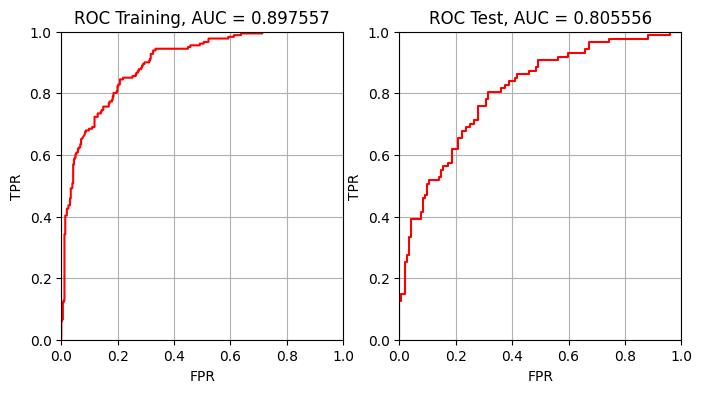

In [21]:
from sklearn import metrics

probs_train = clf.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(clases_train, probs_train[:,1], pos_label=1)
auc = metrics.roc_auc_score(clases_train, probs_train[:,1])

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(fpr, tpr, 'r-')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Training, AUC = %f" % auc)

probs_test = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(clases_test, probs_test[:,1], pos_label=1)
auc = metrics.roc_auc_score(clases_test, probs_test[:,1])

plt.subplot(122)
plt.plot(fpr, tpr, 'r-')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Test, AUC = %f" % auc)

plt.show()

Curva precision-recall:

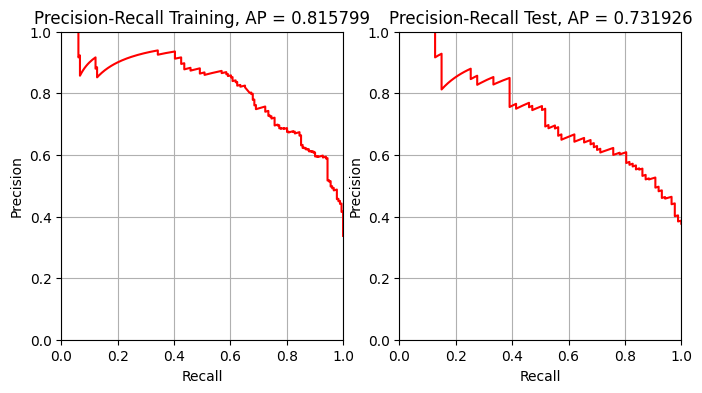

In [22]:
precision, recall, thresholds = metrics.precision_recall_curve(clases_train, probs_train[:,1])
ap = metrics.average_precision_score(clases_train, probs_train[:,1])

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(recall, precision, 'r-')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Training, AP = %f" % ap)

precision, recall, thresholds = metrics.precision_recall_curve(clases_test, probs_test[:,1])
ap = metrics.average_precision_score(clases_test, probs_test[:,1])

plt.subplot(122)
plt.plot(recall, precision, 'r-')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Test, AP = %f" % ap)

plt.show()

Supongamos que queremos elegir el grupo de 50 patrones (de test) con mayor probabilidad de clase = 1. ¿Cuáles elegiríamos? ¿Cuál sería la precisión?

## Ejercicio:

Aplica todo este proceso metodológico al conjunto de datos de clasificación binaria *breast_cancer*, cargado más abajo. Recuerda que es importante estandarizar los datos, dividir en conjuntos de entrenamiento y test y buscar los mejores parámetros para aplicar SVC correctamente.

In [23]:
from sklearn.datasets import load_breast_cancer
d = load_breast_cancer()
X = pd.DataFrame(data=d.data, columns=d.feature_names).astype(float)
clases = pd.DataFrame(d.target)
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
clases

,0
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0
